# Setup Variables

In [69]:
REPO_PATH = '/home/ah19/runtime-monitoring'
DATASET = 'Cifar10'
PREFIX = 'MonileNet'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"
SEED = 42

GPU_NAME = 'cuda:0'

model_setup = {'batchnorm': True, 'dropout': 0.1}

model_config = {
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 15,
    "patience": 15,
    "L2": 0.00,
    "L1": 0.00,
    
    "accuracyThold": 0.90,
    "lossThold": 0.20,
    
    "accuracyTrainThold": 0.90,
    "lossTrainThold": 0.20,
    
    "accuracyTerminateThold": 0.10,
    "lossTerminateThold": 1.0,
}

# Libraries

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import torch
from torchvision.transforms import InterpolationMode
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [71]:
import sys
sys.path.append(REPO_PATH + '/utilities')
sys.path.append(f'{REPO_PATH}/{DATASET}/trainingModels')

In [72]:
from utils import *
from pathManager import fetchPaths
# from Cifar10_CNN import Cifar10_CNN

# model_ = Cifar10_CNN

# GPU Device & Seed

In [73]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [74]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Paths

In [101]:
base = Path(REPO_PATH)
paths = fetchPaths(base, DATASET)

path = paths[DATASET.lower()]
path_dataset = paths['dataset']
path_trainingModels = paths['trainingModels']
path_lastHiddenLayer = paths['lastHiddenLayer']
path_lastHiddenLayer_raw = paths['lastHiddenLayer_raw']
path_savedModels = paths['savedModels']

# # save model and logs to dedicated directory
# path_savedModels = path_savedModels / FILENAME_POSTFIX
# path_savedModels.mkdir(exist_ok=True) # raise error if model name was used previously

path, path_savedModels

(PosixPath('/home/ah19/runtime-monitoring/Cifar10'),
 PosixPath('/home/ah19/runtime-monitoring/Cifar10/savedModels'))

# Load / Split / DataLoader

In [127]:
feature_names = get_labels(DATASET)

# IMPORTANT Augmentation
tf = T.Compose([
    T.ToTensor(),
#     T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_full = get_dataset(DATASET, path_dataset, train=True)
test_data = get_dataset(DATASET, path_dataset, train=False)
len(train_full), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [128]:
val_split = int( len(train_full) * 0.10 )
train_split = len(train_full) - val_split
train_data, val_data = split_data(train_full, [train_split, val_split], SEED)

In [143]:
# transformer_augmentation = T.Compose(
#         [
#             T.ToPILImage(),
#             T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
# #             T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# #             T.RandomCrop(32, padding=4),
# #             T.RandomHorizontalFlip(),
#             T.RandomApply(
#                 [
#                     T.RandomAffine((10, 45)),
#                     T.RandomAffine(0, translate=(0.1, 0.25)),
#                     T.RandomAffine(0, scale=(1.1, 1.25)),
#                 ],
#                 p=0.3,
#             ),
#             T.ToTensor(),
#         ]
#     )
# train_dataloader = get_dataLoader(train_data, model_config['batch_size'], True, collate_fn=collat_fn_augmentation)
train_dataloader = get_dataLoader(train_data, model_config['batch_size'], True)
val_dataloader = get_dataLoader(val_data, model_config['batch_size'], False)
test_dataloader = get_dataLoader(test_data, model_config['batch_size'], False)

# Model

In [144]:
from torchvision.models import mobilenet_v3_small, densenet121, densenet161

In [145]:
# m = densenet161(pretrained=True)
# m

In [151]:
path_savedModels = paths['savedModels']

PREFIX = 'densenet161'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"

path_savedModels = path_savedModels / FILENAME_POSTFIX
path_savedModels.mkdir(exist_ok=True)

class Cifar10_CNN(nn.Module):
    def __init__(self, channels=3, img_dim=32, outneurons=10, last_hidden_neurons=80,
        weight_init="kaiming_uniform", bias=True, dropout=0.0, batchnorm=True):

        super(Cifar10_CNN, self).__init__()

        self.channels = channels
        self.img_dim = img_dim
        self.in_features = channels * img_dim * img_dim
        self.num_classes = outneurons
        self.last_hidden_neurons = last_hidden_neurons
        self.dropout_p = dropout
        self.batchnorm = batchnorm


        self.relu = nn.ReLU()
#         self.flatten = nn.Flatten()
        # scaling data
        self.scaleInputs = nn.BatchNorm2d(channels)
#         self.dropout_l = nn.Dropout(self.dropout_p)
#         self.pool = nn.MaxPool2d(2, 2)

#         self.tl = densenet121(pretrained=True)
#         self.tl.classifier = nn.Linear(self.tl.classifier.in_features, last_hidden_neurons)

#         self.tl = mobilenet_v3_small(pretrained=True)
#         self.tl.classifier[3] = nn.Linear(self.tl.classifier[3].in_features, last_hidden_neurons)

        self.tl = densenet161(pretrained=True)
        self.tl.classifier = nn.Linear(self.tl.classifier.in_features, last_hidden_neurons)

        self.bn = nn.BatchNorm1d(last_hidden_neurons)

        self.output = nn.Linear(last_hidden_neurons, outneurons, bias=bias)


    def forward(self, x):

        x = self._train(x)
        if self.batchnorm: x = self.bn(x)
        x = self.relu(x)
        x = self.output(x)

        return x


    def _train(self, x):
        
        x = self.scaleInputs(x)
        x = self.tl(x)

        return x

    def output_last_layer(self, x):

        x = self._train(x)
        out = x.clone().detach()
        if self.batchnorm: x = self.bn9(x)
        x = self.relu(x)
        x = self.output(x)

        return out, x


    def _sum_weights(self):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.sum()

        return total_weights.item()

    def _sum_abs_weights(self):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.abs().sum()

        return total_weights.item()

    def _l1_regularization(self, alpha=1e-3):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.abs().sum()

        return alpha * total_weights

    def _l2_regularization(self, lambd=1e-3):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.pow(2).sum()

        return lambd * total_weights

    def _elastic_regularization(self, lambd=1e-3, alpha=1e-3):
        return self._l2_regularization(lambd) + self._l1_regularization(alpha)



In [152]:
# skip classes
skip_classes = None
map_classes = None

# skip_classes = set()
# map_classes = {*feature_names.values()} - skip_classes
# map_classes = { v:k for k,v in enumerate(map_classes) }

# add to model_config
# model_config['num_classes'] = len(map_classes)
# model_config['map_classes'] = map_classes
# model_config['skip_classes'] = skip_classes

In [153]:
model_ = Cifar10_CNN

# model
model = model_(**model_setup)
model.to(device)

# model(torch.randn(1, 3, 224, 224).to(device))

summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
Cifar10_CNN                                   --                        --
├─BatchNorm2d: 1-1                            [1, 3, 224, 224]          6
├─DenseNet: 1-2                               [1, 80]                   --
│    └─Sequential: 2-1                        [1, 2208, 7, 7]           --
│    │    └─Conv2d: 3-1                       [1, 96, 112, 112]         14,112
│    │    └─BatchNorm2d: 3-2                  [1, 96, 112, 112]         192
│    │    └─ReLU: 3-3                         [1, 96, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 96, 56, 56]           --
│    │    └─_DenseBlock: 3-5                  [1, 384, 56, 56]          751,392
│    │    └─_Transition: 3-6                  [1, 192, 28, 28]          74,496
│    │    └─_DenseBlock: 3-7                  [1, 768, 28, 28]          2,061,504
│    │    └─_Transition: 3-8                  [1, 384, 14, 14]          296

In [154]:
# initiate log files

modelFile = path_savedModels / f"{FILENAME_POSTFIX}_model.txt"
epochFile = path_savedModels / f"{FILENAME_POSTFIX}_epoch.txt"

modelFile.touch()
epochFile.touch()

modelWriter, epochWriter = start_wrtier(modelFile, epochFile)

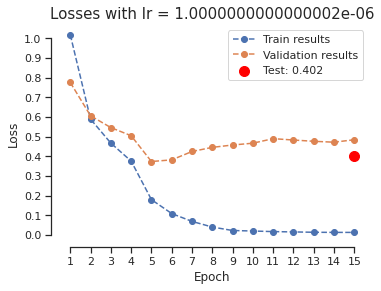

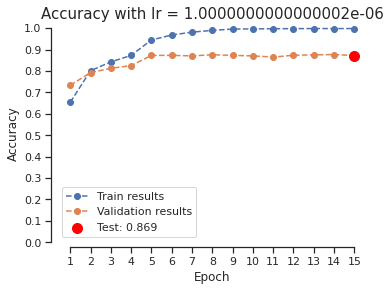

In [155]:
# cost function
loss_function = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['lr'])

# LR Scheduler

# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=model_config['epochs'])

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=model_config['patience'], mode='min',
#     factor=1e-1, min_lr=1e-4, verbose=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=4 )
# lr_scheduler = None

# run_training_testing arguments
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': lr_scheduler,
    'map_classes': map_classes,
    'skip_classes': skip_classes,
    'device': device,
    'model_path': path_savedModels / f"{DATASET}_{PREFIX}.pth.tar",
    'train_dataloader': train_dataloader,
    'val_dataloader': val_dataloader,
    'test_dataloader': test_dataloader,
    'config': model_config,
    'model_file': modelWriter,
    'epoch_file': epochWriter
}

# train
train_losses, val_losses, train_accs, val_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = run_training_testing(**kwargs)

In [156]:
# close log files
close_wrtier(modelFile, epochFile, modelWriter, epochWriter)

# Exporting last hidden layer data

In [ ]:
# create empty model
model = MNIST_Model(**model_setup)
model.to(device)

# load model
# model_file_name = f'{DATASET}_{PREFIX}-test_acc-{round(test_acc,3)}-test_loss-{round(test_loss,3)}.pth.tar'
model_file_name = 'MNIST_Elastic32-test_acc-0.971-test_loss-0.123.pth.tar'
saved_model_path = path_savedModels / model_file_name
load_checkpoint(model, None, None, saved_model_path)

In [ ]:
# export last hidden layer for each data loader

for loader, stage in [
    (train_dataloader, 'train'),
    (val_dataloader, 'val'),
    (test_dataloader, 'test'),
]:
    get_last_hidden_layer(loader, model, device, model.last_hidden_neurons,
                          map_classes, path_lastHiddenLayer_raw, FILENAME_POSTFIX, stage)

# Confusion Matrix

In [ ]:
save_confusion_matrix(confusion_matrix_test, path_savedModels, FILENAME_POSTFIX, 'test')

In [ ]:
confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
fig, ax = plot_confusion_matrix( confusion_matrix_test_norm, map_classes=map_classes, fmt='.2f')